In [1]:
from model import load_as_trt_model
from rchess import Board, Move
from utils import FakeTRTFunc
import numpy as np
from configs import engineplayConfig, selfplayConfig
from mcts import MCTS, debug_search, Node

selfplayConfig["tablebase_search"] = True
mctsSearch = MCTS(selfplayConfig)
use_fake = True
if use_fake:
    trt_func = FakeTRTFunc()
else:
    trt_func, _ = load_as_trt_model("latest")


2025-04-25 19:31:52.147748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from chess import Board as PyBoard
#board = Board("1r2k3/1P6/1K6/8/8/2R5/2p5/8 w - - 0 1")
#board = Board("6k1/8/8/3P4/8/8/8/K7 b - - 0 1")
board = Board("2k5/4p1n1/4Pp2/5P2/5K2/8/3R4/8 b - - 8 6")
pyBoard = PyBoard(board.fen())
#print(board)

In [9]:
move, root, child_visits = mctsSearch.find_best_move(board, None, trt_func, 0, 5.0, True)
debug_search(board, root, 3, 10)
board.push_num(move)
move_uci = Move(move).uci()
pyBoard.push_uci(move_uci)


  +---+---+---+---+---+---+---+---+
  |   |   | k |   |   |   |   |   | 8
  +---+---+---+---+---+---+---+---+
  |   |   |   |   | p |   | n |   | 7
  +---+---+---+---+---+---+---+---+
  |   |   |   |   | P | p |   |   | 6
  +---+---+---+---+---+---+---+---+
  |   |   |   |   |   | P |   |   | 5
  +---+---+---+---+---+---+---+---+
  |   |   |   |   |   | K |   |   | 4
  +---+---+---+---+---+---+---+---+
  |   |   |   |   |   |   |   |   | 3
  +---+---+---+---+---+---+---+---+
  |   |   |   |   |   | R |   |   | 2
  +---+---+---+---+---+---+---+---+
  |   |   |   |   |   |   |   |   | 1
  +---+---+---+---+---+---+---+---+
    a   b   c   d   e   f   g   h

Fen: 2k5/4p1n1/4Pp2/5P2/5K2/8/5R2/8 w - - 11 8
Key: 10a95ef126cecbbb
Elapsed time: 5.22s
Total visits: 39936
--------------------------------------------------------------------------------------------------------------
PV:
1. 0.491103 | f2e2 c8d8 e2g2 g7h5 f4f3 d8c8 g2e2 h5g7 f3f2 c8b7
2. 0.483573 | f2h2 c8b8 h2b2 b8a8 b2b8 a8a7 b8g8

Move.from_uci('f2e2')

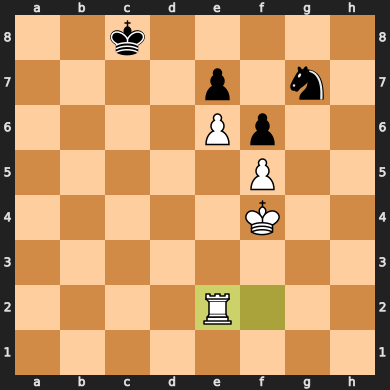

In [10]:
pyBoard

In [29]:
from model import predict_fn
board = Board("5k1r/1b2rp2/pR4pp/1p3n2/2p5/2N5/PP3PPP/3Q2K1 w - -")
image, hash = board.history(engineplayConfig["history_perspective_flip"])
value, policies = predict_fn(trt_func, np.array([image]))
print("Value:", value.numpy())
print("Policies:", policies.numpy())
# Max of policies and min of policies
policies = policies.numpy()[0]
print("Max policy:", np.max(policies))
print("Min policy:", np.min(policies))
print("Mean policy:", np.mean(policies))

Value: [[0.00239372]]
Policies: [[ 0.73828125  0.9121094   0.81933594 ... -0.3786621   0.89160156
   1.0566406 ]]
Max policy: 1.5595703
Min policy: -0.8125
Mean policy: 0.0023056436


In [30]:
from datetime import datetime
import tensorflow as tf
import numpy as np
import os
from configs import trainingConfig as tcfg
from functools import partial

def count_available_samples(config):
    """ Count the number of available samples for training.

    Args:
        config (dict): A dictionary containing the configuration for the project.

    Returns:
        int: The number of available samples for training.
        int: The number of samples to use after sampling.
    """
    sample_dir = os.path.join(config['project_dir'], 'data', 'selfplay_data')
    total_samples = 0
    sampling_ratio = config['sampling_ratio']

    for filename in os.listdir(sample_dir):
        if filename.endswith('.npz'):
            num_positions = int(filename.split('_')[0])
            total_samples += num_positions

    return total_samples, int(total_samples * sampling_ratio)

def load_samples(config, load: int, take: int):
    print(f"Loading {load} samples, taking {take} samples")
    sample_dir = os.path.join(config['project_dir'], 'data', 'selfplay_data')
    samples = []

    loaded_samples = 0

    # Get list of files and sort them by the number of samples (least samples first)
    files = [f for f in os.listdir(sample_dir) if f.endswith('.npz')]
    files.sort(key=lambda f: int(f.split('_')[0]))

    for filename in files:
        if filename.endswith('.npz'):
            file_path = os.path.join(sample_dir, filename)
            data = np.load(file_path)
            images = data['images']
            search_stats = data['search_stats']
            terminal_values = data['terminal_values']
            num_file_samples = len(images)

            if loaded_samples + num_file_samples <= load:
                samples.extend((images[i], (search_stats[i], terminal_values[i])) for i in range(num_file_samples))
                loaded_samples += num_file_samples
            else:
                remaining_samples = load - loaded_samples
                samples.extend((images[i], (search_stats[i], terminal_values[i])) for i in range(remaining_samples))
                loaded_samples += remaining_samples

                # Save the remaining data back to a new file with a new name, {remaining_samples}_{timestamp}
                timestamp = datetime.now().strftime('%F_%T.%f')[:-3]
                new_filename = f"{remaining_samples}_{timestamp}.npz"
                np.savez(os.path.join(sample_dir, new_filename), 
                         images=images[remaining_samples:].astype(np.int64), 
                         search_stats=search_stats[remaining_samples:],
                         terminal_values=terminal_values[remaining_samples:].astype(np.int64))
                
                break
    
    rng = np.random.default_rng()
    # Randomly select num_selected_samples from samples, each sample can be selected only once
    indices = rng.choice(len(samples), size=take, replace=False)
    selected_samples = [samples[i] for i in indices]
    return selected_samples

def create_tf_record(config, samples):
    timestamp = datetime.now().strftime('%F_%T.%f')[:-3]
    save_path = os.path.join(config['project_dir'], 'data', 'train_data', f"{timestamp}.tfrecords")
    with tf.io.TFRecordWriter(save_path) as writer:
        for sample in samples:
            image, (search_stats, terminal_value) = sample
            
            image_features = tf.train.Feature(int64_list=tf.train.Int64List(value=image))
            search_stats_features = tf.train.Feature(float_list=tf.train.FloatList(value=search_stats))
            terminal_value_features = tf.train.Feature(float_list=tf.train.FloatList(value=[terminal_value]))

            example = tf.train.Example(features=tf.train.Features(feature={
                "image": image_features,
                "value_head": terminal_value_features,
                "policy_head": search_stats_features
            }))
            writer.write(example.SerializeToString())
    return save_path

def read_tfrecord(example_proto):
    feature_description = {
        "image": tf.io.FixedLenFeature([109], tf.int64),
        "value_head": tf.io.FixedLenFeature([1], tf.float32),
        "policy_head": tf.io.FixedLenFeature([1858], tf.float32),
    }
    example_proto = tf.io.parse_single_example(example_proto, feature_description)
    return example_proto["image"], {"value_head": example_proto["value_head"], "policy_head": example_proto["policy_head"]}

def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames)  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order)  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def get_dataset(filenames, batch_size, buffer_size=4096):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset


batch_size = 4096
total_samples, sampled_samples = count_available_samples(tcfg)
epochs = sampled_samples // batch_size

num_samples = batch_size * epochs

samples = load_samples(tcfg, round(num_samples / tcfg['sampling_ratio']), num_samples)
tf_record = create_tf_record(tcfg, samples)
data_set = get_dataset(tf_record, 4096, buffer_size=40960*2)


Loading 122880 samples, taking 73728 samples


In [31]:
sample = samples[2]

image, (search_stats, terminal_value) = sample
            
image_features = tf.train.Feature(int64_list=tf.train.Int64List(value=image))
search_stats_features = tf.train.Feature(float_list=tf.train.FloatList(value=search_stats))
terminal_value_features = tf.train.Feature(float_list=tf.train.FloatList(value=[terminal_value]))

example = tf.train.Example(features=tf.train.Features(feature={
    "image": image_features,
    "value_head": terminal_value_features,
    "policy_head": search_stats_features
}))

for line in str(example).split('\n'):
  print(line)
print('...')
example_proto = example.SerializeToString()

features {
  feature {
    key: "value_head"
    value {
      float_list {
        value: 0
      }
    }
  }
  feature {
    key: "policy_head"
    value {
      float_list {
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0.0450563207
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0.0475594476
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
  

In [32]:
feature_description = {
    "image": tf.io.FixedLenFeature([109], tf.int64),
    "value_head": tf.io.FixedLenFeature([1], tf.float32),
    "policy_head": tf.io.FixedLenFeature([1858], tf.float32),
}
parsed_example = tf.io.parse_single_example(example_proto, feature_description)
image = parsed_example['image']
terminal_value = parsed_example['value_head']
search_stats = parsed_example['policy_head']
print("Terminal value:", terminal_value.numpy())

#value_head = example_proto["value_head"]
#policy_head = example_proto["policy_head"]

Terminal value: [0.]


In [33]:
from model import generate_model
model = generate_model()


In [34]:
value, policies = model.predict(np.expand_dims(image, axis=0))
print("Value:", value[0][0])
print("Policies:", policies[0])

1/1 [==============================] - 0s 256ms/step
Value: 0.4847373
Policies: [-0.2803736   0.25383404 -0.07286161 ... -0.1049448   0.15348823
 -0.45927405]


In [35]:
print("Samples loaded:", len(samples))
print("Sampling ratio:", tcfg['sampling_ratio'])
# Count how many times in terminal_values in samples the value is -1.0, 0.0 and 1.0
count = {1.0: 0, 0.0: 0, -1.0: 0}
for sample in samples:
    _, (_, terminal_value) = sample
    count[terminal_value] += 1
print("Count of terminal values in samples:", count)
# Sum the counted values
sum = 0
for k, v in count.items():
    sum += v
print("Sum of terminal values in samples:", sum)

Samples loaded: 73728
Sampling ratio: 0.6
Count of terminal values in samples: {1.0: 17117, 0.0: 39264, -1.0: 17347}
Sum of terminal values in samples: 73728


In [36]:
from configs import trainingConfig as config
import os
import numpy as np

sample_dir = os.path.join(config['project_dir'], 'data', 'selfplay_data')
restore_dir = os.path.join(config['restore_dir'])
samples = []

loaded_samples = 0

# Get list of files and sort them by the number of samples (least samples first)
files = [f for f in os.listdir(sample_dir) if f.endswith('.npz')]
print("Files:", files)

np.random.shuffle(files)
print("Shuffled files:", files)


Files: ['10000_2025-03-22_15:05:23.931.npz', '10000_2025-03-23_01:06:58.591.npz', '4454_2025-03-24_05:25:51.496.npz', '10000_2025-03-23_03:56:54.105.npz', '3815_2025-04-01_15:02:53.081.npz', '10000_2025-03-22_17:34:39.545.npz', '10000_2025-03-22_14:44:04.791.npz', '4611_2025-03-24_05:25:53.933.npz', '10000_2025-03-23_04:18:04.553.npz', '10000_2025-03-22_15:47:44.971.npz', '10000_2025-03-23_05:41:06.177.npz', '10000_2025-03-22_16:30:07.635.npz', '10000_2025-03-22_18:16:06.354.npz', '10000_2025-03-22_15:26:49.662.npz', '10000_2025-03-23_00:03:22.926.npz']
Shuffled files: ['10000_2025-03-22_15:05:23.931.npz', '10000_2025-03-23_01:06:58.591.npz', '4611_2025-03-24_05:25:53.933.npz', '10000_2025-03-22_15:47:44.971.npz', '10000_2025-03-22_18:16:06.354.npz', '10000_2025-03-22_16:30:07.635.npz', '10000_2025-03-23_00:03:22.926.npz', '10000_2025-03-23_05:41:06.177.npz', '10000_2025-03-22_14:44:04.791.npz', '10000_2025-03-22_17:34:39.545.npz', '10000_2025-03-23_03:56:54.105.npz', '10000_2025-03-23

In [37]:
from configs import selfplayConfig
import os
import re
from math import ceil

def _load_mosca_sts() -> list:
    """Parses the STS test suite file and returns a list of tests

    Returns:
        list: List of tests. Each test is a dictionary with the following:
            - fen: FEN string of the position
            - group: Group name (15 motifs in total)
            - results: Dictionary with UCI move as key and score as value (multiple winning moves but one is still best)
    """

    fileR = open(os.path.join(selfplayConfig['project_dir'], 'test_suites', 'STS1-STS15_LAN_v3.epd'), "r")
    lines = fileR.readlines()
    fileR.close()

    tests = []
    for line in lines:
        line_info = line.split('; ')
        fen = line_info[0].split(' bm ')[0]
        for info in line_info:
            if 'id' in info:
                id = re.findall(r'"([^"]*)"', info)[0]
        group = id[:-4]
        uci_moves = re.findall(r'"([^"]*)"', line_info[-1])[0].split(' ')
        moves_points = [int(points) for points in re.findall(r'"([^"]*)"', line_info[-2])[0].split(' ')]
        results = {uci_moves[i]: moves_points[i] for i in range(len(uci_moves))}
        test = {"fen": fen, "group": group, "results": results}
        tests.append(test)
    return tests

def _chunk_into_n(lst: list, n: int) -> list:
    """Splits an array into n chunks

    Args:
        lst (list): List to be splitted
        n (int): Number of chunks

    Returns:
        list: List of n chunks (last chunk may be smaller than the rest)
    """
    size = ceil(len(lst) / n)
    return list(
        map(lambda x: lst[x * size:x * size + size],
        list(range(n)))
    )

num_actors = 1
tests = _load_mosca_sts()
test_chunks = _chunk_into_n(tests, num_actors)
print(len(test_chunks))
print(len(test_chunks[0]))

1
1500


In [38]:
from model import load_as_trt_model
from rchess import Board, Move
import numpy as np
from configs import selfplayConfig
from mcts import MCTS, debug_search, Node
import time
from multiprocessing import Process

mctsSearch = MCTS(selfplayConfig)
trt_func, _ = load_as_trt_model(model_version="latest")

2025-04-01 15:03:27.456823: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


In [39]:
from rchess import Board, Move
from configs import selfplayConfig

def terminal_value(on_turn, winner):
    if winner == on_turn:
        return 1.0
    else:
        return -1.0

# Scholars mate
images = []

moves = ["e2e4", "e7e5", "f1c4", "b8c6", "d1h5", "g8f6", "h5f3", "e8e7"]
moves_played = 0

board = Board()
while 1:
    terminal, winner = board.terminal()
    if terminal:
        break

    # MCTS SEARCH

    if moves_played >= len(moves):
        break
    move = moves[moves_played]

    history, _  = board.history(False)
    images.append(history)

    board.push_uci(move)
    moves_played += 1

terminal_values = [0.0] * moves_played
if winner is not None:
    for i in range(moves_played):
        terminal_values[i] = terminal_value(True if i % 2 == 0 else False, winner)

print("Terminal values:", terminal_values)
print(board)

Terminal values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

  +---+---+---+---+---+---+---+---+
  | r |   | b | q |   | b |   | r | 8
  +---+---+---+---+---+---+---+---+
  | p | p | p | p | k | p | p | p | 7
  +---+---+---+---+---+---+---+---+
  |   |   | n |   |   | n |   |   | 6
  +---+---+---+---+---+---+---+---+
  |   |   |   |   | p |   |   |   | 5
  +---+---+---+---+---+---+---+---+
  |   |   | B |   | P |   |   |   | 4
  +---+---+---+---+---+---+---+---+
  |   |   |   |   |   | Q |   |   | 3
  +---+---+---+---+---+---+---+---+
  | P | P | P | P |   | P | P | P | 2
  +---+---+---+---+---+---+---+---+
  | R | N | B |   | K |   | N | R | 1
  +---+---+---+---+---+---+---+---+
    a   b   c   d   e   f   g   h

Fen: r1bq1b1r/ppppkppp/2n2n2/4p3/2B1P3/5Q2/PPPP1PPP/RNB1K1NR w KQ - 6 5
Key: 2dfcf5db51071a30


In [40]:
import numpy as np
from utils import convert_u64_to_np

def visualize_image(image, ts):
    
    p1_img = np.zeros((8, 8), dtype=np.int8)
    p2_img = np.zeros((8, 8), dtype=np.int8)
    curr_ts_p1 = image[(ts*13):(ts*13)+6]
    curr_ts_p2 = image[(ts*13)+6:(ts*13)+12]


    for piece in range(6):
        p1_pieces = curr_ts_p1[piece]
        p2_pieces = curr_ts_p2[piece]
        piece_value = piece + 1
        for i in range(8):
            for j in range(8):
                if p1_pieces[i,j] != 0:
                    p1_img[i,j] = piece_value
                if p2_pieces[i,j] != 0:
                    p2_img[i,j] = piece_value
    

    return p1_img, p2_img

images_np = convert_u64_to_np(images)

In [41]:

image = images_np[-1]
for i in range(8):
    p1, p2 = visualize_image(image, i)

    print("TS: ", i)
    print(p1)
    print("---------------------------")
    print(p2)
    print("   ")



TS:  0
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 2 0 0 2 0 0]
 [1 1 1 1 0 1 1 1]
 [4 0 3 5 6 3 0 4]]
---------------------------
[[4 2 3 0 6 0 2 4]
 [1 1 1 1 0 1 1 1]
 [0 0 0 0 0 5 0 0]
 [0 0 3 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
   
TS:  1
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 2 0 0 2 0 0]
 [1 1 1 1 0 1 1 1]
 [4 0 3 5 6 3 0 4]]
---------------------------
[[4 2 3 0 6 0 2 4]
 [1 1 1 1 0 1 1 1]
 [0 0 0 0 0 0 0 0]
 [0 0 3 0 1 0 0 0]
 [0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
   
TS:  2
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 2 0 0 0 0 0]
 [1 1 1 1 0 1 1 1]
 [4 0 3 5 6 3 2 4]]
---------------------------
[[4 2 3 0 6 0 2 4]
 [1 1 1 1 0 1 1 1]
 [0 0 0 0 0 0 0 0]
 [0 0 3 0 1 0 0 0]
 [0 0 0 0 0 0 0 5]
 [0 0 0 0 0 0 0 0]
 [0 0 0 

In [1]:
import os
import numpy as np
def count_available_samples(config):
    sample_dir = os.path.join(config['project_dir'], 'data', 'selfplay_data')
    total_samples = 0
    sampling_ratio = config['sampling_ratio']

    for filename in os.listdir(sample_dir):
        if filename.endswith('.npz'):
            num_positions = int(filename.split('_')[0])
            total_samples += num_positions

    return total_samples, int(total_samples * sampling_ratio)

def load_samples(config, load: int, take: int):
    rng = np.random.default_rng()

    sample_dir = os.path.join(config['project_dir'], 'data', 'selfplay_data')
    restore_dir = os.path.join(config['restore_dir'])
    samples = []

    # Get list of files and sort them by the number of samples (least samples first)
    files = [f for f in os.listdir(sample_dir) if f.endswith('.npz')]
    rng.shuffle(files)

    for filename in files:
        file_path = os.path.join(sample_dir, filename)
        data = np.load(file_path)
        images = data['images']
        search_stats = data['search_stats']
        terminal_values = data['terminal_values']
        num_file_samples = len(images)

        if len(samples) + num_file_samples <= load:
            for image, search_stat, terminal_value in zip(images, search_stats, terminal_values):
                samples.append(
                    {
                        "image": image,
                        "value_head": terminal_value,
                        "policy_head": search_stat
                    }
                )
        else:
            remaining_samples = load - len(samples)
            for image, search_stat, terminal_value in zip(images[:remaining_samples], search_stats[:remaining_samples], terminal_values[:remaining_samples]):
                samples.append(
                    {
                        "image": image,
                        "value_head": terminal_value,
                        "policy_head": search_stat
                    }
                )
             
        if len(samples) >= load:
                break
    
    # Randomly select num_selected_samples from samples, each sample can be selected only once
    indices = rng.choice(len(samples), size=take, replace=False)
    selected_samples = [samples[i] for i in indices]
    rng.shuffle(selected_samples)
    return selected_samples

In [2]:
from configs import trainingConfig as config
batch_size = 4096
sampling_ratio = 0.6

config["batch_size"] = batch_size
config["sampling_ratio"] = sampling_ratio

total_samples, sampled_samples = count_available_samples(config)
epochs = sampled_samples // batch_size
print("Total samples: ", total_samples)
print("Epochs possible: ", epochs)
num_samples = batch_size * epochs
samples = load_samples(config, round(num_samples / config['sampling_ratio']), num_samples)
print("Samples loaded: ", len(samples))

Total samples:  132880
Epochs possible:  19
Samples loaded:  77824


In [3]:
import numpy as np

images = np.array([sample["image"] for sample in samples])
search_stats =  np.array([sample["policy_head"] for sample in samples])
terminal_values =  np.array([sample["value_head"] for sample in samples], dtype=np.float32)

print("Images shape:", images.shape)
print("Search stats shape:", search_stats.shape)
print("Terminal values shape:", terminal_values.shape)
print("Terminal values:", terminal_values)

count = {1.0: 0, 0.0: 0, -1.0: 0}
for terminal_value in terminal_values:
    count[terminal_value] += 1
print(count)

Images shape: (77824, 109)
Search stats shape: (77824, 1858)
Terminal values shape: (77824,)
Terminal values: [ 0. -1.  0. ...  0.  1.  1.]
{1.0: 18594, 0.0: 40941, -1.0: 18289}


In [4]:
from model import generate_model

model = generate_model()

2025-04-01 15:08:07.928620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-01 15:08:09.314459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6177 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5


In [14]:
indices = np.random.choice(len(images), size=15, replace=False)
values, policies = model.predict(images[indices])
print("Values:", values)


1/1 [==============================] - 0s 23ms/step
Values: [[ 0.03153405]
 [ 0.20435306]
 [-0.05304952]
 [-0.00075198]
 [-0.00179523]
 [ 0.00356553]
 [ 0.00165041]
 [ 0.01062426]
 [-0.0616665 ]
 [ 0.03843891]
 [ 0.07385221]
 [ 0.27732942]
 [-0.01167445]
 [-0.0376427 ]
 [ 0.00209222]]


In [6]:
import tensorflow as tf
lr_callback = tf.keras.callbacks.LearningRateScheduler(
        lambda _: config['learning_rate'],
)
callbacks = [lr_callback]

learning_rate = 0.02
config["learning_rate"] = learning_rate

model.fit(images, 
        (terminal_values, search_stats),
        batch_size=1024, 
        initial_epoch=0, 
        epochs=epochs, 
        steps_per_epoch=1,
        callbacks=callbacks,
        verbose=1)


2025-04-01 15:08:15.572529: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 578387968 exceeds 10% of free system memory.
2025-04-01 15:08:15.992517: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 578387968 exceeds 10% of free system memory.


Epoch 1/19
1/1 [==============================] - 1s 1s/step - loss: 8.8143 - value_head_loss: 0.6572 - policy_head_loss: 7.8345 - lr: 0.0200
Epoch 2/19
1/1 [==============================] - 0s 33ms/step - loss: 8.7287 - value_head_loss: 0.6285 - policy_head_loss: 7.7776 - lr: 0.0200
Epoch 3/19
1/1 [==============================] - 0s 38ms/step - loss: 8.5962 - value_head_loss: 0.5926 - policy_head_loss: 7.6810 - lr: 0.0200
Epoch 4/19
1/1 [==============================] - 0s 35ms/step - loss: 8.4612 - value_head_loss: 0.6242 - policy_head_loss: 7.5144 - lr: 0.0200
Epoch 5/19
1/1 [==============================] - 0s 36ms/step - loss: 8.2971 - value_head_loss: 0.5857 - policy_head_loss: 7.3889 - lr: 0.0200
Epoch 6/19
1/1 [==============================] - 0s 34ms/step - loss: 8.0462 - value_head_loss: 0.5465 - policy_head_loss: 7.1772 - lr: 0.0200
Epoch 7/19
1/1 [==============================] - 0s 35ms/step - loss: 7.9953 - value_head_loss: 0.5770 - policy_head_loss: 7.0958 - lr: 0

In [ ]:
#values, policies = predict_fn(trt_func, images[indices])
#print("Values:", values)

2025-04-01 15:03:38.748746: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2025-04-01 15:03:38.748792: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2025-04-01 15:03:43.993883: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


In [ ]:
import tensorflow as tf
from model import predict_fn

from tensorflow.python.compiler.tensorrt import trt_convert as trt
from configs import selfplayConfig as config
import os
precision_mode = "FP16"
build_model = True

def input_fn():
    np_data = np.load(os.path.join(config['project_dir'], 'data', 'conversion_data', 'histories.npz'))
    histories = np_data["histories"]
    # Yield the histories in batches of size defaultConfig["batch_size"]
    for i in range(0, len(histories), config["num_vl_searches"]):
        yield (histories[i:i + config["num_vl_searches"]],)

model_save_path = os.path.join(config['project_dir'], 'data', 'models', "testing", 'saved_model')

tf_model = model
tf_model.save(model_save_path)

conversion_params = trt.TrtConversionParams(
    precision_mode=precision_mode,
    use_calibration=True,
)

converter = trt.TrtGraphConverterV2(
    input_saved_model_dir=model_save_path,
    conversion_params=conversion_params,
)

if precision_mode == "INT8":
    converter.convert(calibration_input_fn=input_fn)
else:
    converter.convert()

if precision_mode != "INT8" and build_model:
    converter.build(input_fn=input_fn)

converter.save(model_save_path)


INFO:tensorflow:Assets written to: /home/tomaz/ChessBot_v2/data/models/tmp/saved_model/assets


INFO:tensorflow:Assets written to: /home/tomaz/ChessBot_v2/data/models/tmp/saved_model/assets


INFO:tensorflow:Linked TensorRT version: (8, 4, 3)


INFO:tensorflow:Linked TensorRT version: (8, 4, 3)


INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)


INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)


INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.
2025-04-01 13:30:33.026521: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-01 13:30:33.026616: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2025-04-01 13:30:33.027784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6087 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5


INFO:tensorflow:Clearing prior device assignments in loaded saved model


INFO:tensorflow:Clearing prior device assignments in loaded saved model
2025-04-01 13:30:33.990139: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-01 13:30:33.990233: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2025-04-01 13:30:33.991451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6087 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5
2025-04-01 13:30:34.606699: W tensorflow/compiler/tf2tensorrt/convert/trt_optimization_pass.cc:186] Calibration with FP32 or FP16 is not implemented. Falling back to use_calibration = False.Note that the default value of use_calibration is True.
2025-04-01 13:30:34.781643: W tensorflow/compiler/tf2tensorrt/segment/segment.cc:962] 

############################################################################

INFO:tensorflow:Assets written to: /home/tomaz/ChessBot_v2/data/models/tmp/saved_model/assets


INFO:tensorflow:Assets written to: /home/tomaz/ChessBot_v2/data/models/tmp/saved_model/assets


In [ ]:
loaded_model = tf.saved_model.load(model_save_path)
trt_func = loaded_model.signatures['serving_default']

2025-04-01 13:31:14.737201: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


In [9]:
words = "position startpos moves e2e3 e7e5"
words = words.strip().split()
moves_index = words.index("startpos") + 1
if "moves" in words:
    moves = words[moves_index + 1:]
print("Moves:", moves)

Moves: ['e2e3', 'e7e5']


In [10]:
neki = [1, 2, 3]
neki2 = neki[-2:]
print(neki2)

[2, 3]


In [1]:
from rchess import Board
board = Board("rnbqkbnr/pppp1ppp/8/4p3/8/N3P3/PPPP1PPP/R1BQKBNR b KQkq - 0 2")
print(board)


  +---+---+---+---+---+---+---+---+
  | r | n | b | q | k | b | n | r | 8
  +---+---+---+---+---+---+---+---+
  | p | p | p | p |   | p | p | p | 7
  +---+---+---+---+---+---+---+---+
  |   |   |   |   |   |   |   |   | 6
  +---+---+---+---+---+---+---+---+
  |   |   |   |   | p |   |   |   | 5
  +---+---+---+---+---+---+---+---+
  |   |   |   |   |   |   |   |   | 4
  +---+---+---+---+---+---+---+---+
  | N |   |   |   | P |   |   |   | 3
  +---+---+---+---+---+---+---+---+
  | P | P | P | P |   | P | P | P | 2
  +---+---+---+---+---+---+---+---+
  | R |   | B | Q | K | B | N | R | 1
  +---+---+---+---+---+---+---+---+
    a   b   c   d   e   f   g   h

Fen: rnbqkbnr/pppp1ppp/8/4p3/8/N3P3/PPPP1PPP/R1BQKBNR b KQkq - 0 2
Key: 5376f0d24d31f542


In [97]:
import math

def eval_to_centipawn(Q):
    cp = 111.714640912 * math.tan(1.5620688421 * (2*Q-1))
    
    return cp

In [99]:
# Example values
Q_values = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
is_white_turn = True

# Print centipawn values
for Q in Q_values:
    cp = eval_to_centipawn(Q)
    #print(cp)
    print(f"Q: {Q:.2f}, cp/100: {cp/100:.2f}")

Q: 0.50, cp/100: 0.00
Q: 0.55, cp/100: 0.18
Q: 0.60, cp/100: 0.36
Q: 0.65, cp/100: 0.57
Q: 0.70, cp/100: 0.81
Q: 0.75, cp/100: 1.11
Q: 0.80, cp/100: 1.52
Q: 0.85, cp/100: 2.16
Q: 0.90, cp/100: 3.36
Q: 0.95, cp/100: 6.71
Q: 1.00, cp/100: 128.00
